## **Building Good Training Datasets- Data preprocessing**

The quality of the data and the amount of useful information that it contains are key factors that
determine how well a machine learning algorithm can learn. Therefore, it is absolutely critical to
ensure that we examine and preprocess a dataset before we feed it to a machine learning algorithm.
In this chapter, we will discuss the essential data preprocessing techniques that will help us to build
good machine learning models.

The topics that we will cover in this chapter are as follows:

1. Removing and imputing missing values from the dataset
2. Getting categorical data into shape for machine learning algorithms
3. Selecting relevant features for the model construction

In [1]:
from IPython.display import Image
%matplotlib inline

### Dealing with missing data


Identifying missing values in tabular data

In [2]:
import pandas as pd
from io import StringIO
import sys

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [3]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [4]:
# access the underlying NumPy array
# via the `values` attribute
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

**Eliminating training examples or features with missing values**


In [5]:
# remove rows that contain missing values

df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [6]:
# remove columns that contain missing values

df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [7]:
# only drop rows where all columns are NaN

df.dropna(how='all')  

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [8]:
# drop rows that have fewer than 3 real values 

print(df.dropna(thresh=4))

print("\n")

print(df.dropna(thresh=3))

     A    B    C    D
0  1.0  2.0  3.0  4.0


      A     B     C    D
0   1.0   2.0   3.0  4.0
1   5.0   6.0   NaN  8.0
2  10.0  11.0  12.0  NaN


In [10]:
# only drop rows where NaN appear in specific columns (here: 'C')
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


#### Imputing missing values

In [14]:
# again: our original array
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

Often, the removal of training examples or dropping of entire feature columns is simply not feasible,
because we might lose too much valuable data. In this case, we can use different interpolation tech-
niques to estimate the missing values from the other training examples in our dataset. One of the
most common interpolation techniques is mean imputation, where we simply replace the missing
value with the mean value of the entire feature column. A convenient way to achieve this is by using
the SimpleImputer class from scikit-learn, as shown in the following code:

In [15]:
# impute missing values via the column mean

from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

Here, we replaced each NaN value with the corresponding mean, which is separately calculated for
each feature column. Other options for the strategy parameter are median or most_frequent , where
the latter replaces the missing values with the most frequent values. This is useful for imputing cate-
gorical feature values, for example, a feature column that stores an encoding of color names, such as
red, green, and blue. We will encounter examples of such data later in this chapter.

In [17]:
df.fillna(df.mean()) #alternative and convenient approach using pandas

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


In the previous section, we used the SimpleImputer class from scikit-learn to impute missing values
in our dataset. The SimpleImputer class is part of the so-called transformer API in scikit-learn, which
is used for implementing Python classes related to data transformation. (Please note that the scikit-
learn transformer API is not to be confused with the transformer architecture that is used in natural
language processing, which we will cover in more detail in Chapter 16, Transformers – Improving Natural
Language Processing with Attention Mechanisms.) The two essential methods of those estimators are
fit and transform . The fit method is used to learn the parameters from the training data, and the
transform method uses those parameters to transform the data. Any data array that is to be trans-
formed needs to have the same number of features as the data array that was used to fit the model.

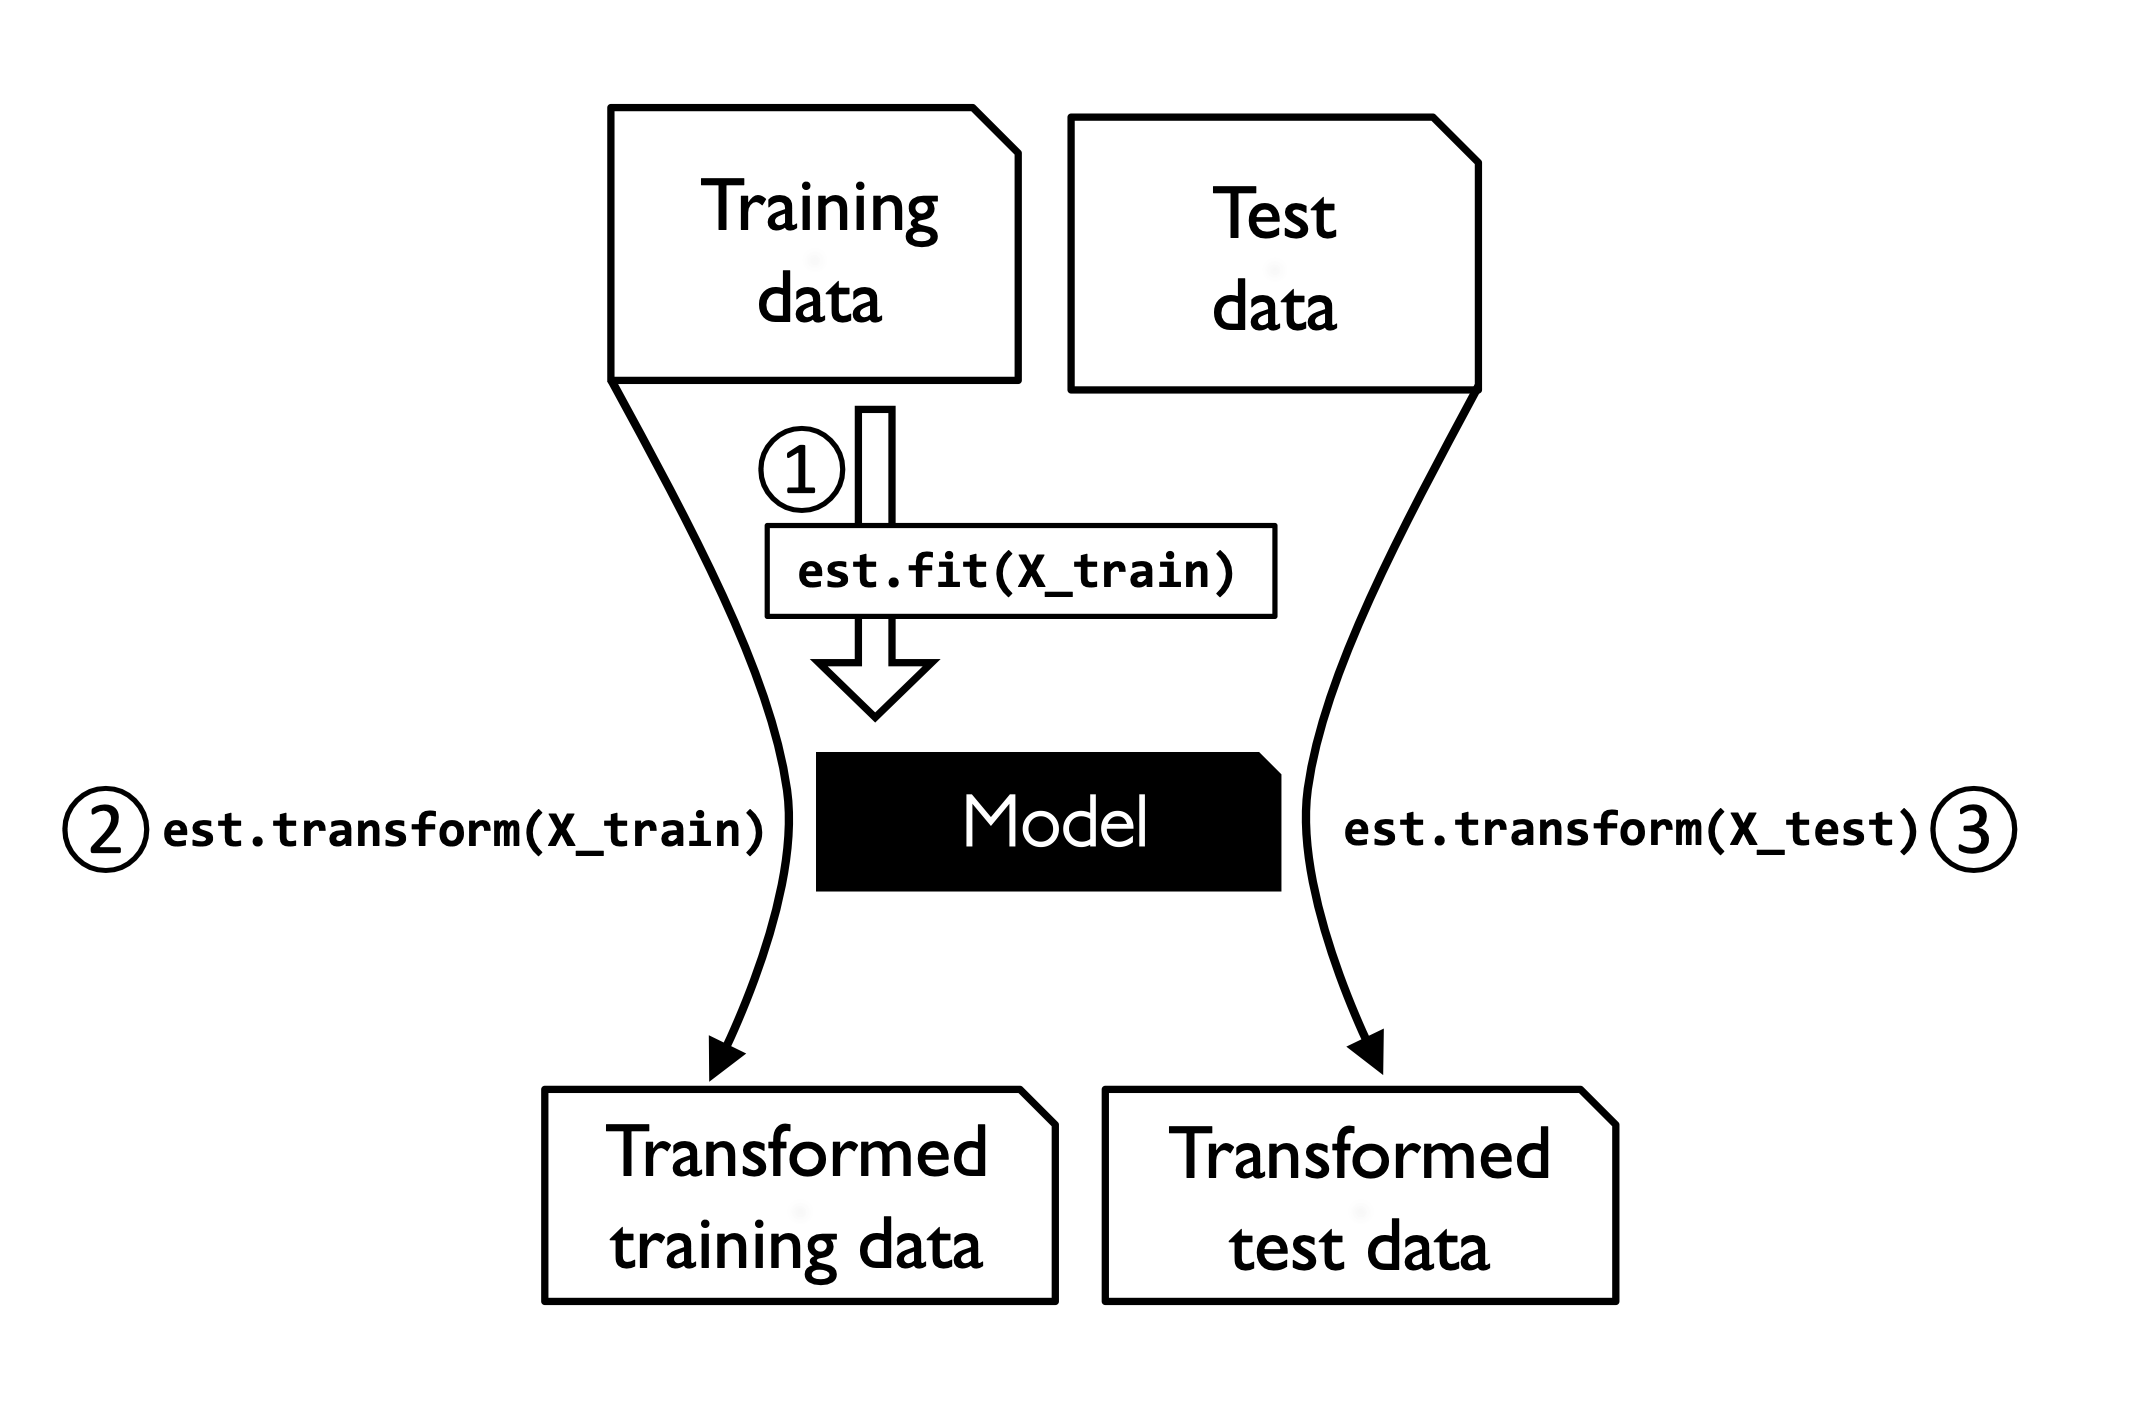

In [21]:
# Understanding the scikit-learn estimator API
Image(filename='figures/04_02.png', width=500) 


The classifiers that we used in Chapter 3, A Tour of Machine Learning Classifiers Using Scikit-Learn, belong
to the so-called estimators in scikit-learn, with an API that is conceptually very similar to the scikit-
learn transformer API. Estimators have a predict method but can also have a transform method, as
you will see later in this chapter. As you may recall, we also used the fit method to learn the parame-
ters of a model when we trained those estimators for classification. However, in supervised learning
tasks, we additionally provide the class labels for fitting the model, which can then be used to make
predictions about new, unlabeled data examples via the predict method, as illustrated in Figure 4.3:

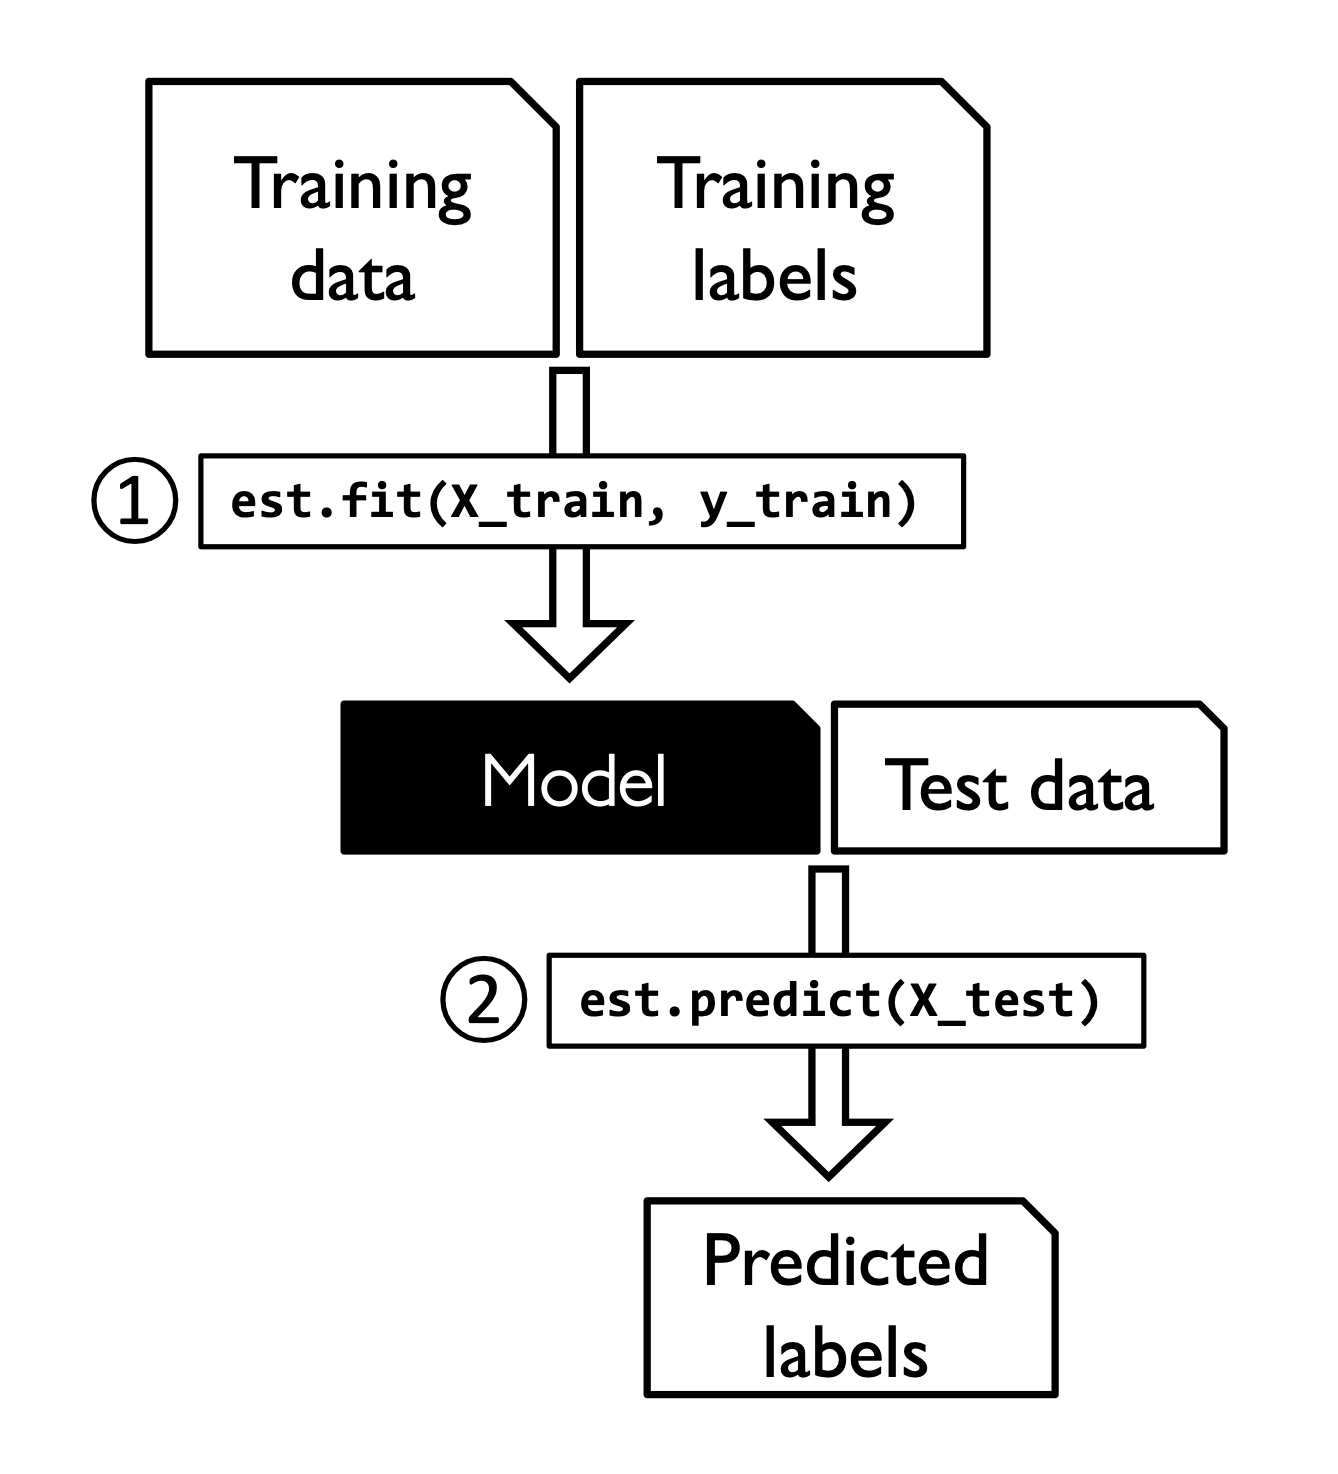

In [20]:
Image(filename='figures/04_03.png', width=400) 


### Handling categorical data

Nominal and Ordinal Features

So far, we have only been working with numerical values. However, it is not uncommon for real-world
datasets to contain one or more categorical feature columns. In this section, we will make use of sim-
ple yet effective examples to see how to deal with this type of data in numerical computing libraries.
When we are talking about categorical data, we have to further distinguish between ordinal and nom-
inal features. Ordinal features can be understood as categorical values that can be sorted or ordered.
For example, t-shirt size would be an ordinal feature, because we can define an order: XL > L > M. In
contrast, nominal features don’t imply any order; to continue with the previous example, we could
think of t-shirt color as a nominal feature since it typically doesn’t make sense to say that, for example,
red is larger than blue.

In [22]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


Mapping ordinal features


In [23]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [24]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

Encoding class labels


Many machine learning libraries require that class labels are encoded as integer values. Although most
estimators for classification in scikit-learn convert class labels to integers internally, it is considered
good practice to provide class labels as integer arrays to avoid technical glitches. To encode the class
labels, we can use an approach similar to the mapping of ordinal features discussed previously. We
need to remember that class labels are not ordinal, and it doesn’t matter which integer number we
assign to a particular string label. Thus, we can simply enumerate the class labels, starting at 0 :

In [25]:
import numpy as np

# create a mapping dict
# to convert class labels from strings to integers
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [26]:
# to convert class labels from strings to integers
df['classlabel'] = df['classlabel'].map(class_mapping)
df


,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [27]:
# reverse the class label mapping
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


Alternatively, there is a convenient LabelEncoder class directly implemented in scikit-learn to achieve
this:

In [28]:
from sklearn.preprocessing import LabelEncoder

# Label encoding with sklearn's LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

In [29]:
# reverse mapping
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

### Performing one-hot encoding on nominal features


In the previous Mapping ordinal features section, we used a simple dictionary mapping approach to
convert the ordinal size feature into integers. Since scikit-learn’s estimators for classification treat
class labels as categorical data that does not imply any order (nominal), we used the convenient
LabelEncoder to encode the string labels into integers. We could use a similar approach to transform
the nominal color column of our dataset, as follows:

In [30]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X


array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

After executing the preceding code, the first column of the NumPy array, X , now holds the new color
values, which are encoded as follows:
• blue = 0
• green = 1
• red = 2
If we stop at this point and feed the array to our classifier, we will make one of the most common
mistakes in dealing with categorical data. Can you spot the problem? Although the color values don’t
come in any particular order, common classification models, such as the ones covered in the previous
chapters, will now assume that green is larger than blue , and red is larger than green . Although this
assumption is incorrect, a classifier could still produce useful results. However, those results would
not be optimal.
A common workaround for this problem is to use a technique called one-hot encoding. The idea behind
this approach is to create a new dummy feature for each unique value in the nominal feature column.
Here, we would convert the color feature into three new features: blue , green , and red . Binary values
can then be used to indicate the particular color of an example; for example, a blue example can be
encoded as blue=1 , green=0 , red=0 . To perform this transformation, we can use the OneHotEncoder
that is implemented in scikit-learn’s preprocessing module:

In [31]:
from sklearn.preprocessing import OneHotEncoder

X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

Note that we applied the OneHotEncoder to only a single column, (X[:, 0].reshape(-1, 1)) , to avoid
modifying the other two columns in the array as well. If we want to selectively transform columns in a
multi-feature array, we can use the ColumnTransformer , which accepts a list of (name, transformer,
column(s)) tuples as follows:

In [32]:
from sklearn.compose import ColumnTransformer

X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([ ('onehot', OneHotEncoder(), [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [33]:
# one-hot encoding via pandas

pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,False,True,False
1,13.5,2,False,False,True
2,15.3,3,True,False,False


In [34]:
# multicollinearity guard in get_dummies

pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,True,False
1,13.5,2,False,True
2,15.3,3,False,False


In order to drop a redundant column via the OneHotEncoder , we need to set drop='first' and set
categories='auto' as follows:

In [35]:
# multicollinearity guard for the OneHotEncoder

color_ohe = OneHotEncoder(categories='auto', drop='first')
c_transf = ColumnTransformer([ ('onehot', color_ohe, [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X).astype(float)

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

Optional: Encoding Ordinal Features


If we are unsure about the numerical differences between the categories of ordinal features, or the difference between two ordinal values is not defined, we can also encode them using a threshold encoding with 0/1 values. For example, we can split the feature "size" with values M, L, and XL into two new features "x > M" and "x > L". Let's consider the original DataFrame:

In [36]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


We can use the apply method of pandas' DataFrames to write custom lambda expressions in order to encode these variables using the value-threshold approach:

In [37]:
df['x > M'] = df['size'].apply(lambda x: 1 if x in {'L', 'XL'} else 0)
df['x > L'] = df['size'].apply(lambda x: 1 if x == 'XL' else 0)

del df['size']
df

,color,price,classlabel,x > M,x > L
0,green,10.1,class2,0,0
1,red,13.5,class1,1,0
2,blue,15.3,class2,1,1


Partitioning a dataset into a separate training and test set


In [38]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)


df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [39]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

### Bringing features onto the same scale


Feature scaling is a crucial step in our preprocessing pipeline that can easily be forgotten. Decision
trees and random forests are two of the very few machine learning algorithms where we don’t need to
worry about feature scaling. Those algorithms are scale-invariant. However, the majority of machine
learning and optimization algorithms behave much better if features are on the same scale, as we saw
in Chapter 2, Training Simple Machine Learning Algorithms for Classification, when we implemented the
gradient descent optimization algorithm.

The importance of feature scaling can be illustrated by a simple example. Let’s assume that we have
two features where one feature is measured on a scale from 1 to 10 and the second feature is measured
on a scale from 1 to 100,000, respectively.

When we think of the squared error function in Adaline from Chapter 2, it makes sense to say that
the algorithm will mostly be busy optimizing the weights according to the larger errors in the second
feature. Another example is the k-nearest neighbors (KNN) algorithm with a Euclidean distance
measure: the computed distances between examples will be dominated by the second feature axis.

![Screenshot from 2023-07-01 15-05-32.png](<attachment:Screenshot from 2023-07-01 15-05-32.png>)
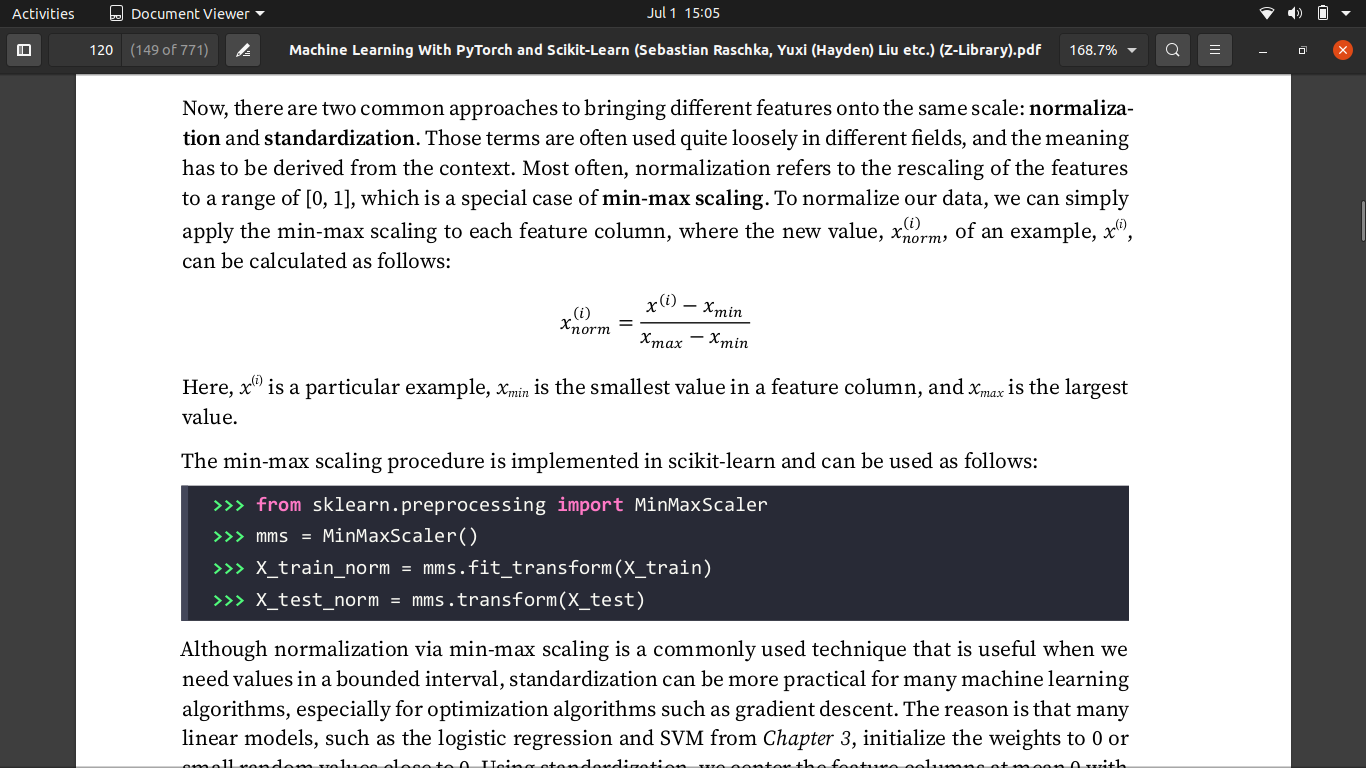

In [40]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

![Screenshot from 2023-07-01 15-04-45.png](<attachment:Screenshot from 2023-07-01 15-04-45.png>)
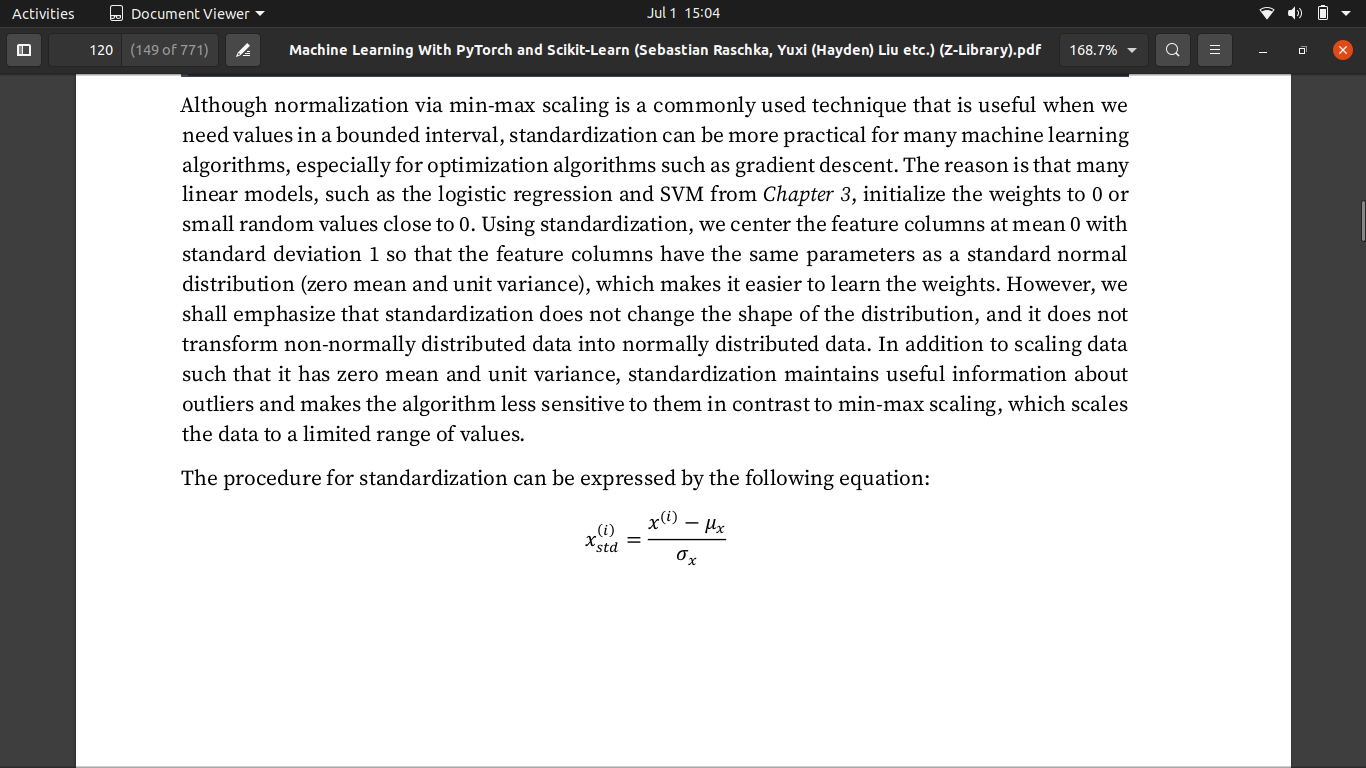

A visual example:



![Screenshot from 2023-07-01 15-02-41.png](<attachment:Screenshot from 2023-07-01 15-02-41.png>)
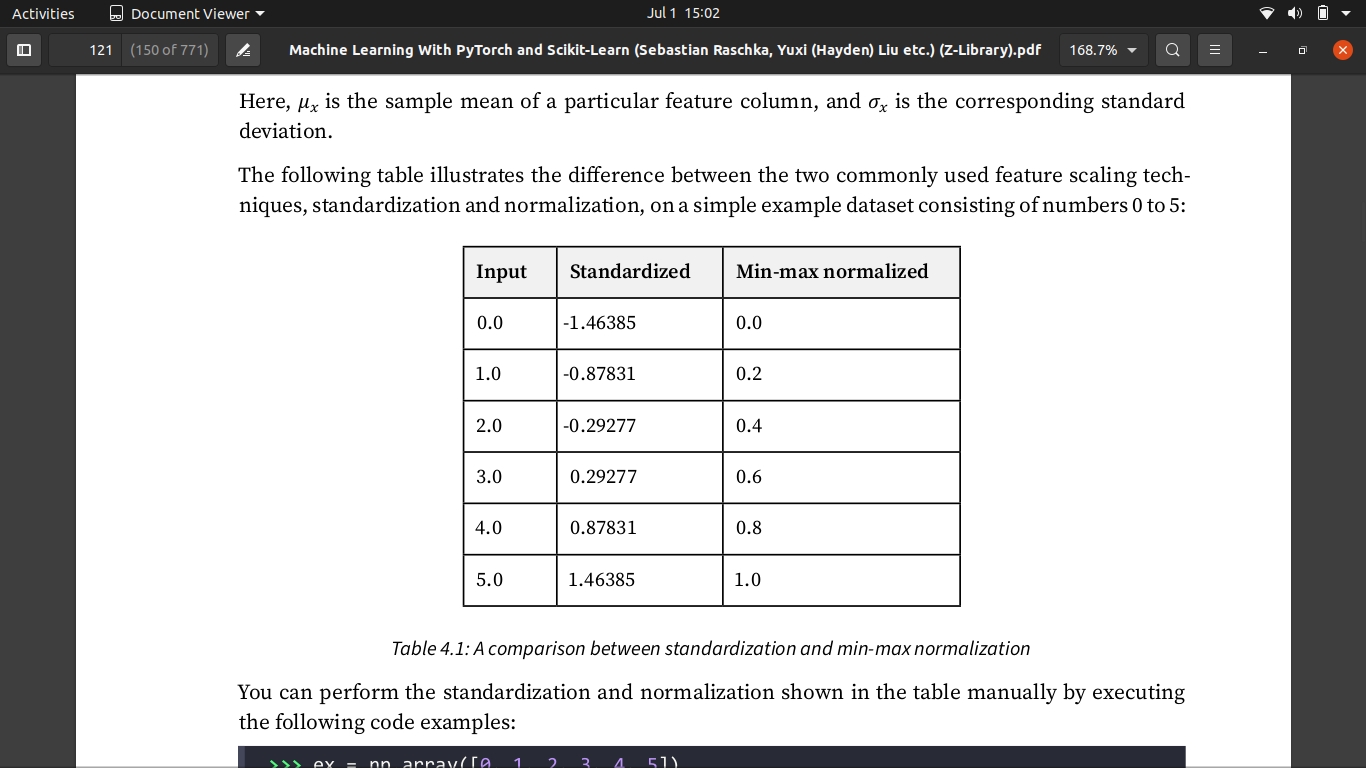

In [42]:
ex = np.array([0, 1, 2, 3, 4, 5])

print('standardized:', (ex - ex.mean()) / ex.std())

# Please note that pandas uses ddof=1 (sample standard deviation) 
# by default, whereas NumPy's std method and the StandardScaler
# uses ddof=0 (population standard deviation)

# normalize
print('normalized:', (ex - ex.min()) / (ex.max() - ex.min()))

standardized: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
normalized: [0.  0.2 0.4 0.6 0.8 1. ]


Similar to the MinMaxScaler class, scikit-learn also implements a class for standardization:

In [ ]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

Again, it is also important to highlight that we fit the StandardScaler class only once—on the training
data—and use those parameters to transform the test dataset or any new data point.
Other, more advanced methods for feature scaling are available from scikit-learn, such as RobustScaler .

RobustScaler is especially helpful and recommended if we are working with small datasets that
contain many outliers. Similarly, if the machine learning algorithm applied to this dataset is prone
to overfitting, RobustScaler can be a good choice. Operating on each feature column independently,
RobustScaler removes the median value and scales the dataset according to the 1st and 3rd quartile of
the dataset (that is, the 25th and 75th quantile, respectively) such that more extreme values and outliers
become less pronounced. The interested reader can find more information about RobustScaler in
the official scikit-learn documentation at https://scikit-learn.org/stable/modules/generated/
sklearn.preprocessing.RobustScaler.html .

Selecting meaningful features
...
If we notice that a model performs much better on a training dataset than on the test dataset, this ob-
servation is a strong indicator of overfitting. As we discussed in Chapter 3, A Tour of Machine Learning
Classifiers Using Scikit-Learn, overfitting means the model fits the parameters too closely with regard
to the particular observations in the training dataset but does not generalize well to new data; we say
that the model has a high variance. The reason for the overfitting is that our model is too complex for
the given training data. Common solutions to reduce the generalization error are as follows:
• Collect more training data
• Introduce a penalty for complexity via regularization
• Choose a simpler model with fewer parameters
• Reduce the dimensionality of the data
Collecting more training data is often not applicable. In Chapter 6, Learning Best Practices for Model
Evaluation and Hyperparameter Tuning, we will learn about a useful technique to check whether more
training data is helpful. In the following sections, we will look at common ways to reduce overfitting
by regularization and dimensionality reduction via feature selection, which leads to simpler models
by requiring fewer parameters to be fitted to the data. Then, in Chapter 5, Compressing Data via Dimen-
sionality Reduction, we will take a look at additional feature extraction techniques.


L1 and L2 regularization as penalties against model complexity
A geometric interpretation of L2 regularization

A geometric interpretation of L2 regularization
As mentioned in the previous section, L2 regularization adds a penalty term to the loss function that
effectively results in less extreme weight values compared to a model trained with an unregularized
loss function.
To better understand how L1 regularization encourages sparsity, let’s take a step back and take a look
at a geometric interpretation of regularization. Let’s plot the contours of a convex loss function for
two weight coefficients, w 1 and w 2 .
Here, we will consider the mean squared error (MSE) loss function that we used for Adaline in Chapter
2, which computes the squared distances between the true and predicted class labels, y and 𝑦𝑦𝑦 , aver-
aged over all N examples in the training set. Since the MSE is spherical, it is easier to draw than the
loss function of logistic regression; however, the same concepts apply. Remember that our goal is to
find the combination of weight coefficients that minimize the loss function for the training data, as
shown in Figure 4.5 (the point in the center of the ellipses):"

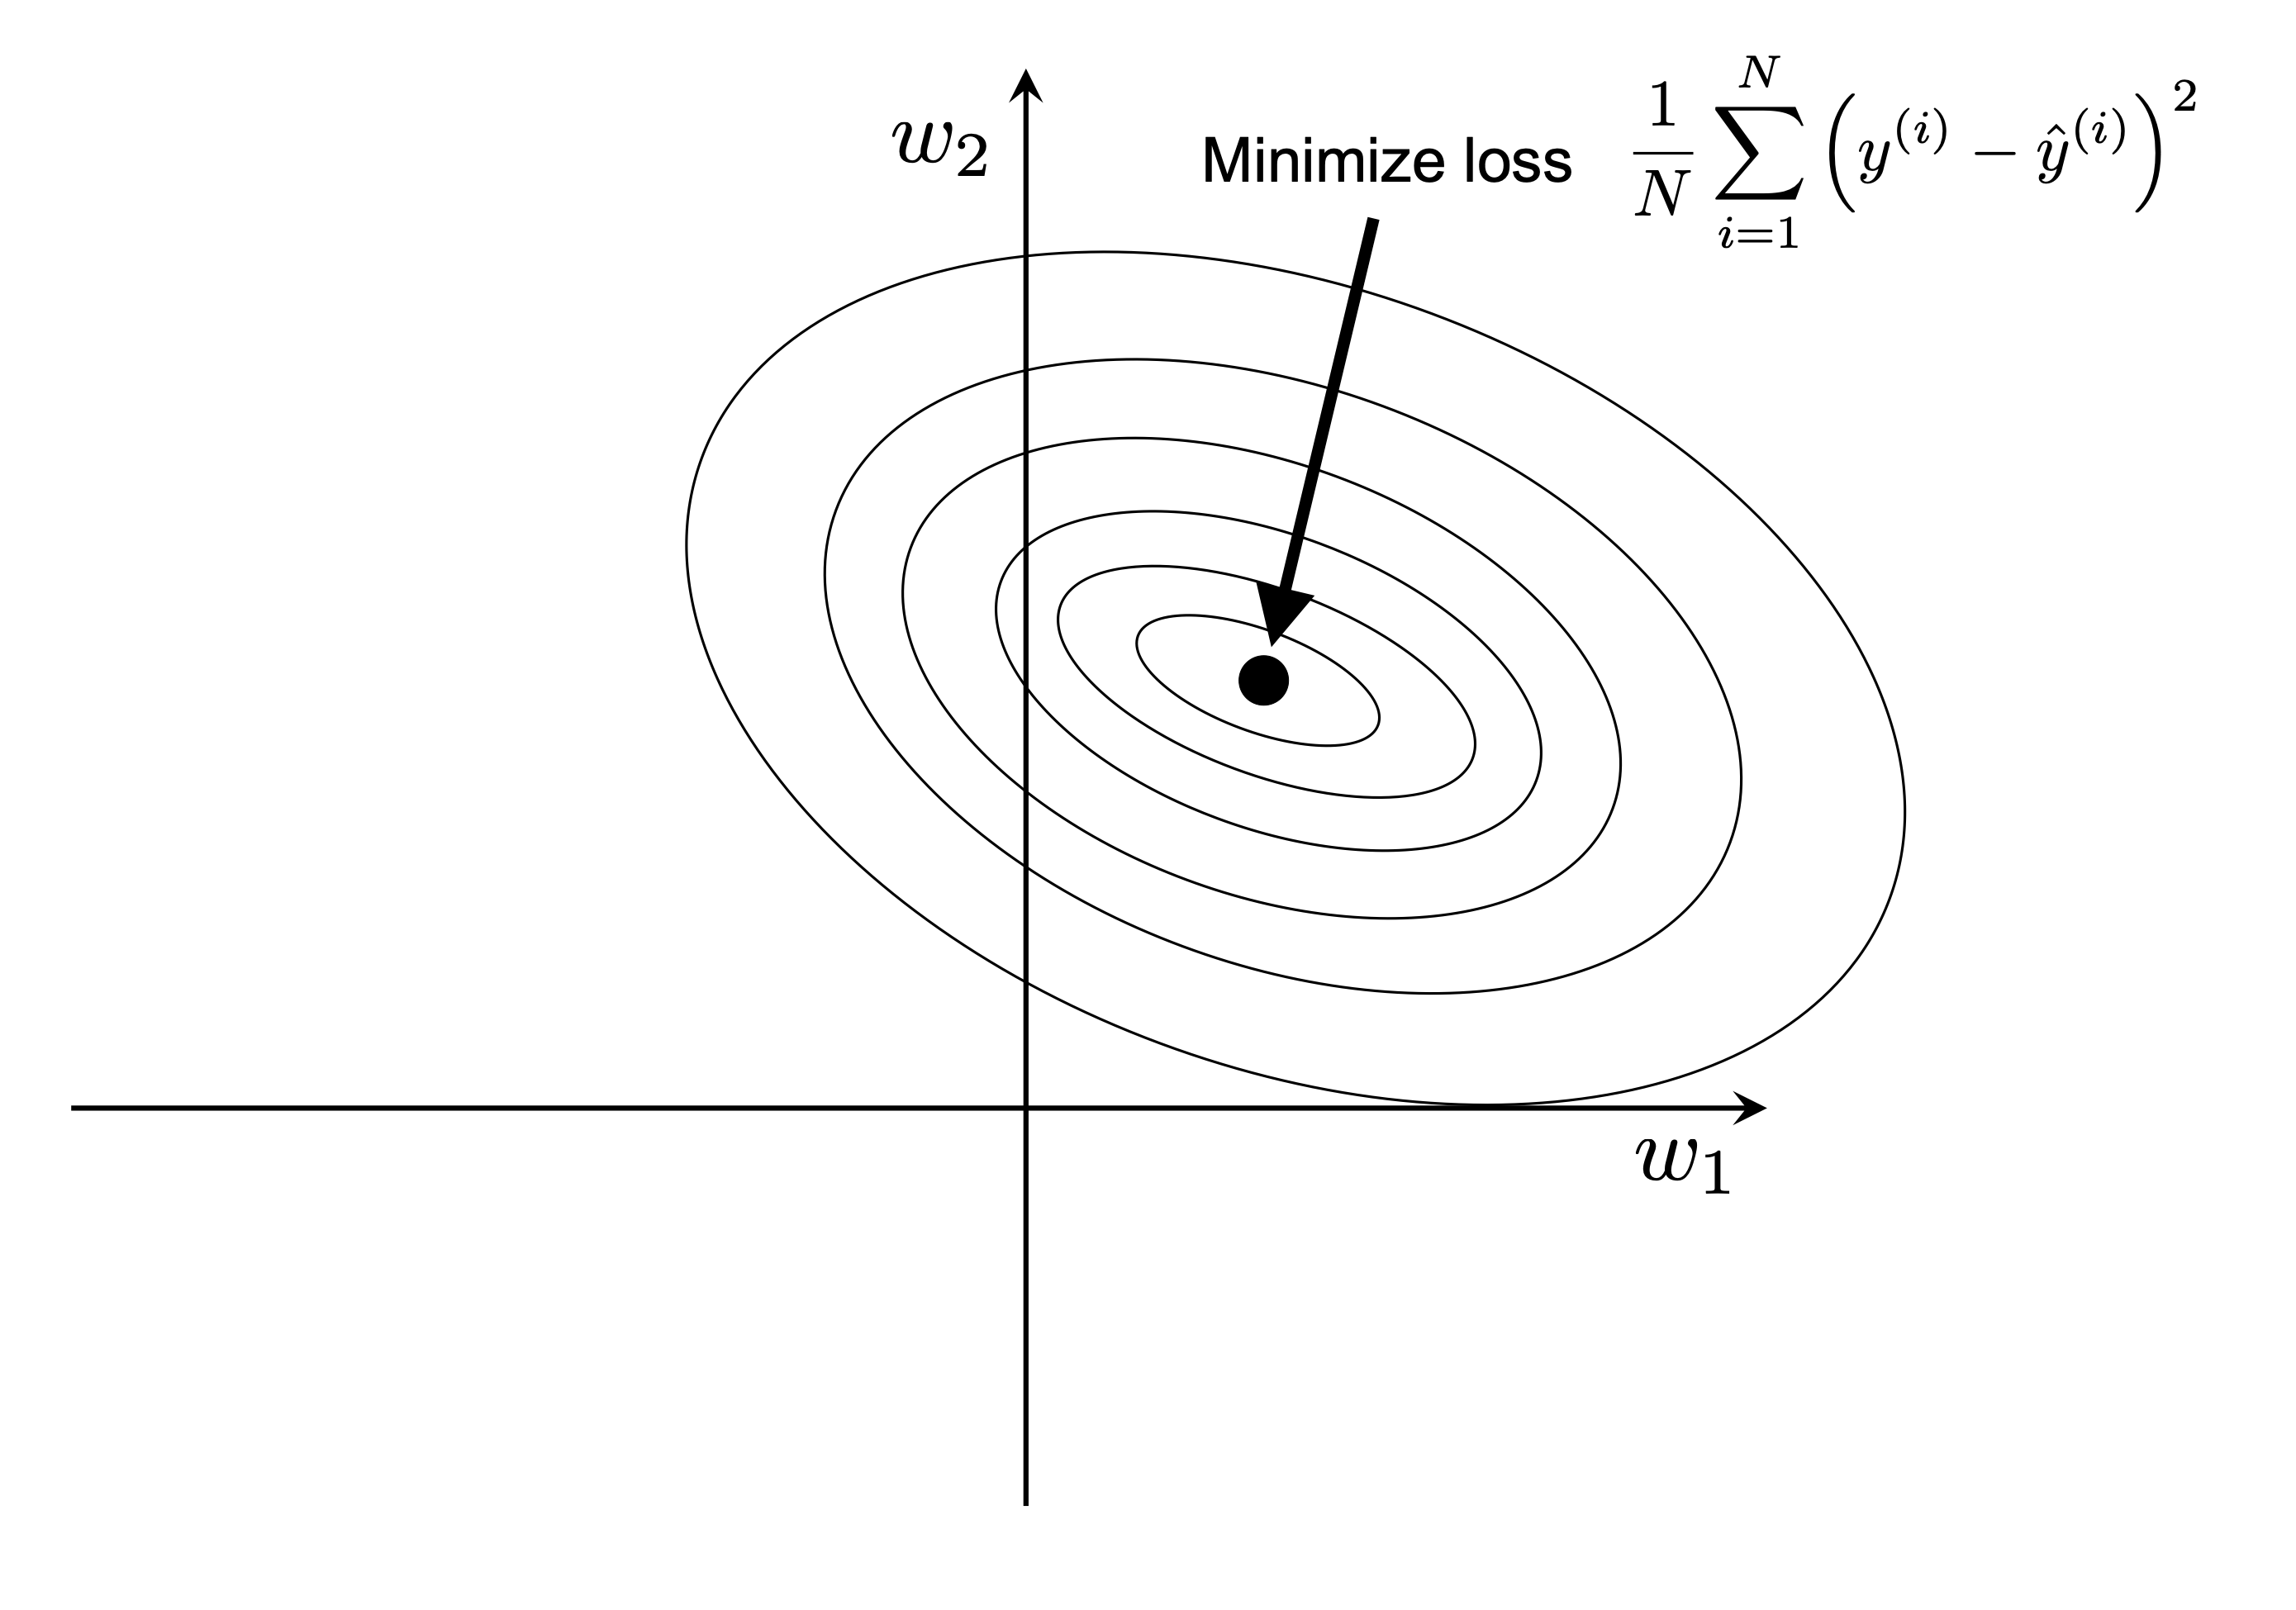

In [43]:
Image(filename='figures/04_05.png', width=500) 


We can think of regularization as adding a penalty term to the loss function to encourage smaller
weights; in other words, we penalize large weights. Thus, by increasing the regularization strength via
the regularization parameter, 𝜆𝜆 , we shrink the weights toward zero and decrease the dependence of our
model on the training data. Let’s illustrate this concept in the following figure for the L2 penalty term:

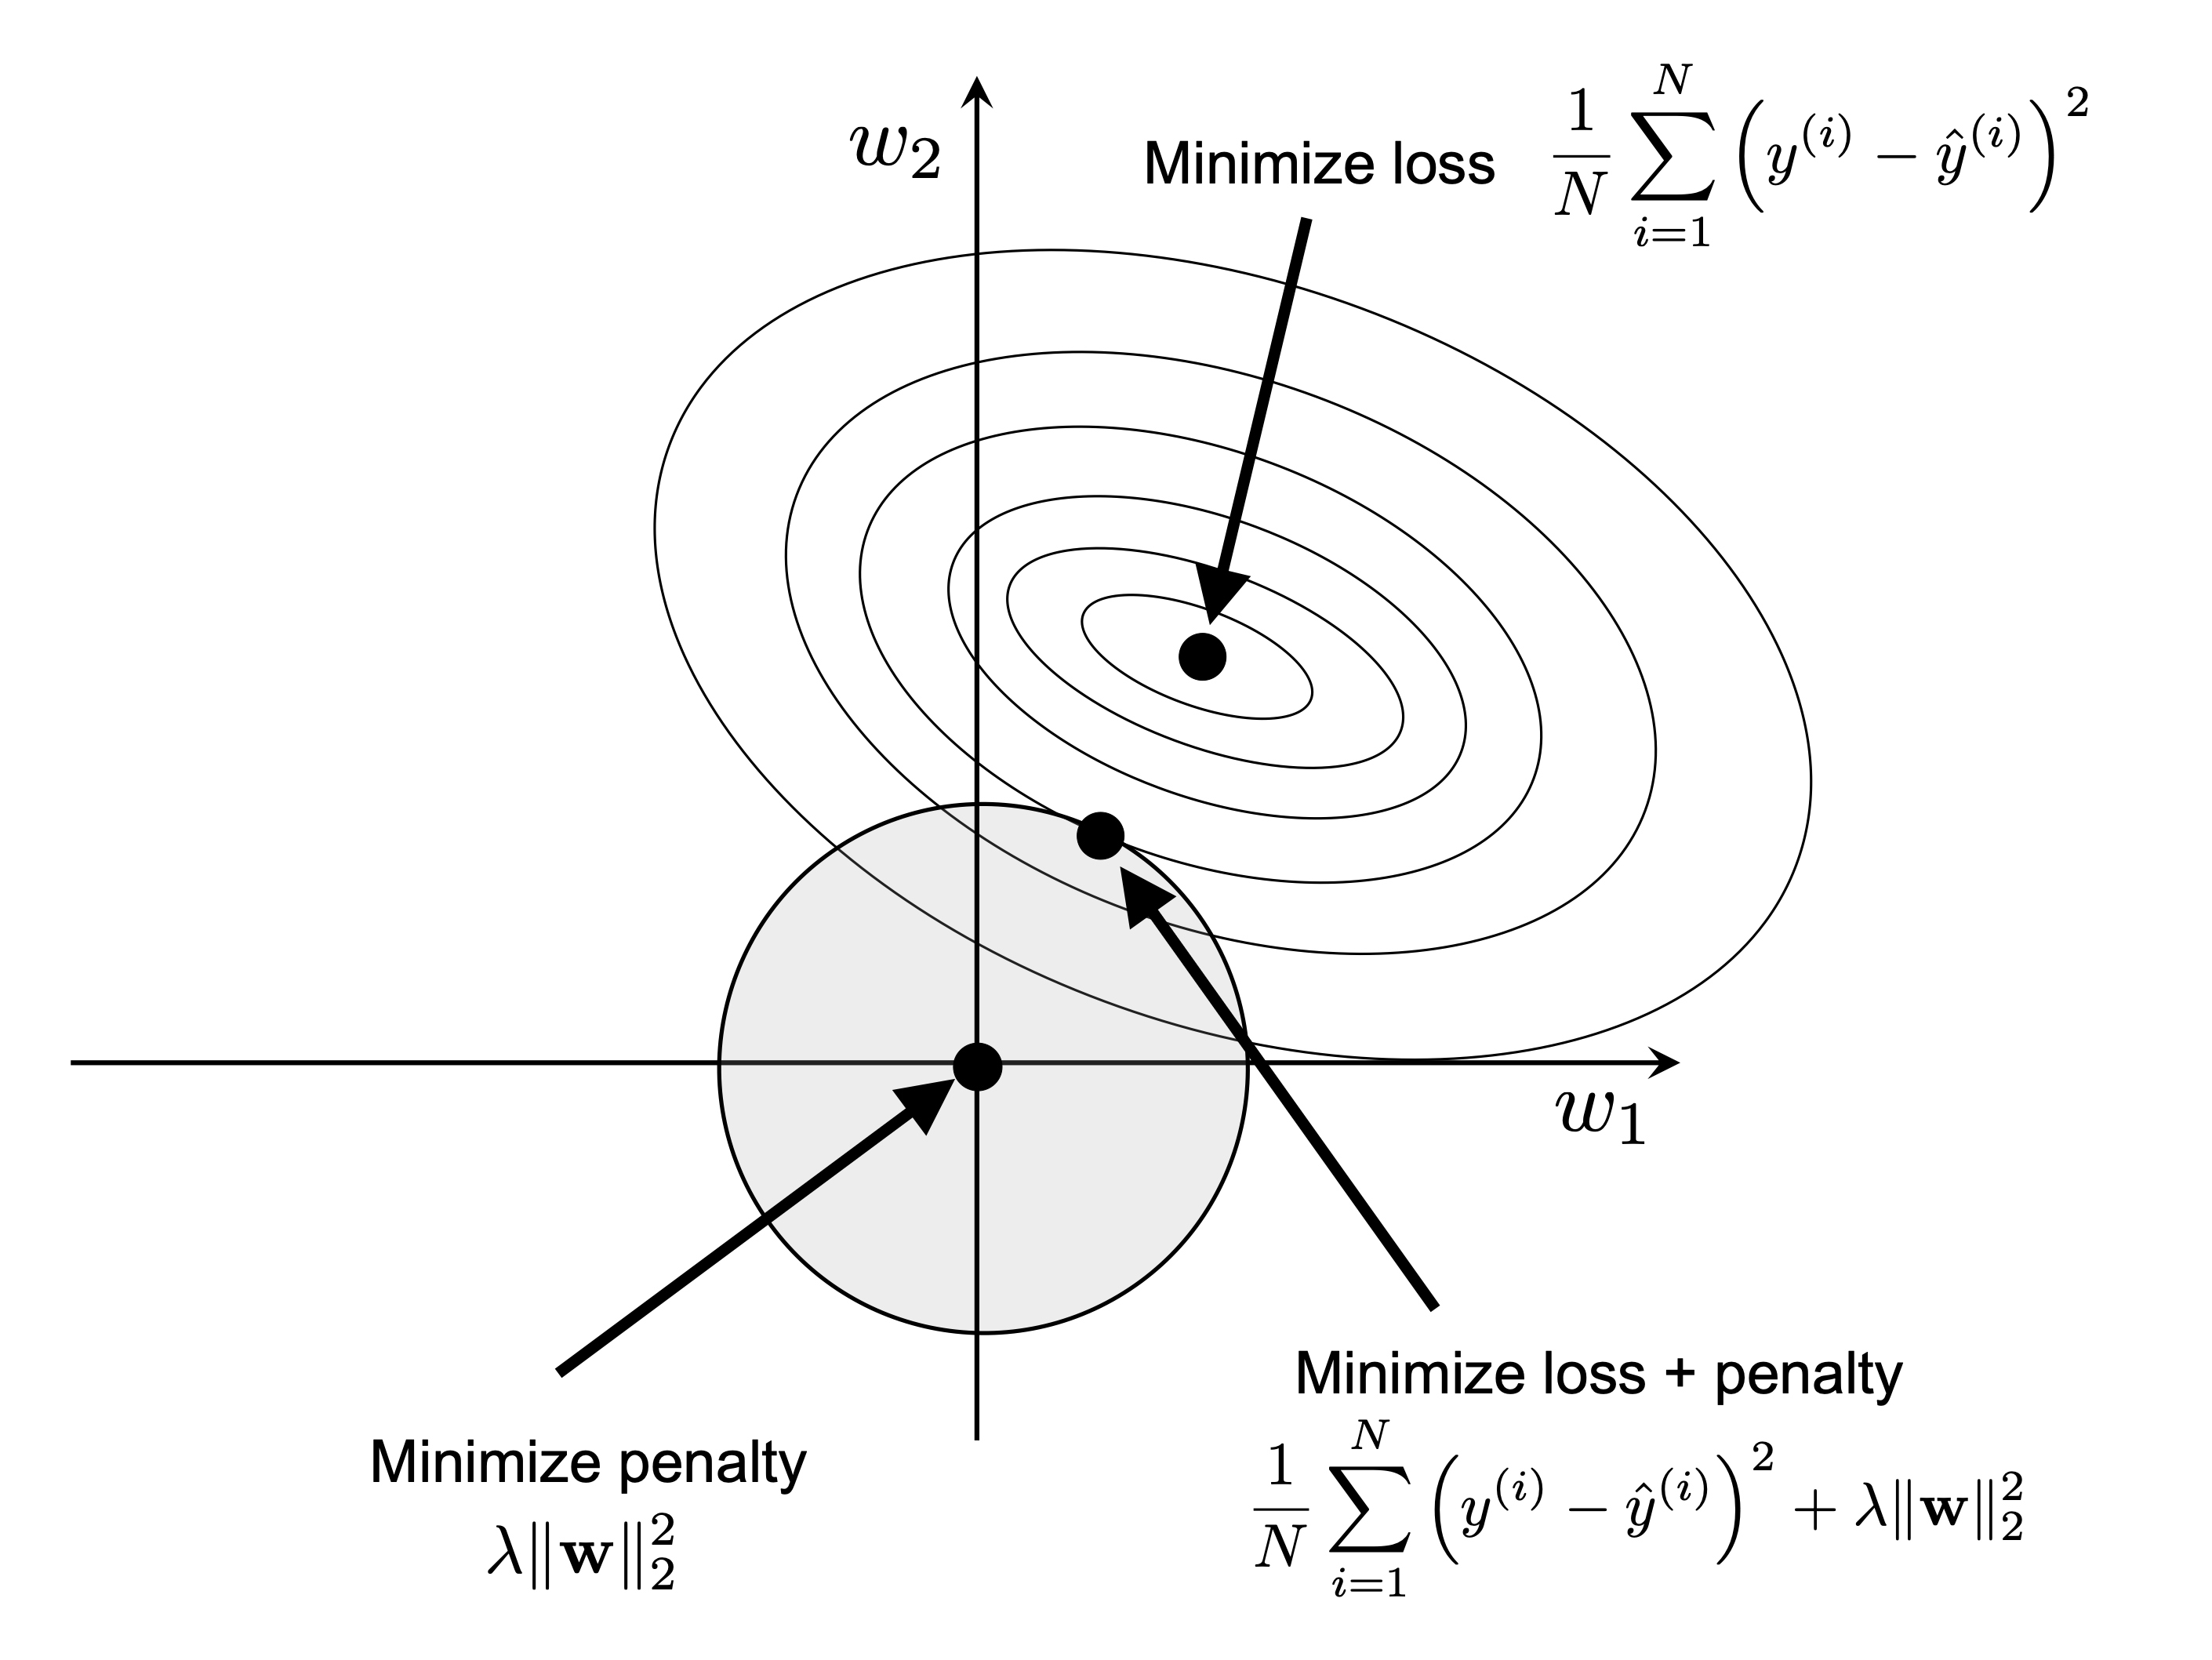

In [46]:
Image(filename='figures/04_06.png', width=500) 


The quadratic L2 regularization term is represented by the shaded ball. Here, our weight coefficients
cannot exceed our regularization budget—the combination of the weight coefficients cannot fall outside
the shaded area. On the other hand, we still want to minimize the loss function. Under the penalty
constraint, our best effort is to choose the point where the L2 ball intersects with the contours of the
unpenalized loss function. The larger the value of the regularization parameter, 𝜆𝜆 , gets, the faster the
penalized loss grows, which leads to a narrower L2 ball. For example, if we increase the regularization
parameter toward infinity, the weight coefficients will become effectively zero, denoted by the center
of the L2 ball. To summarize the main message of the example, our goal is to minimize the sum of
the unpenalized loss plus the penalty term, which can be understood as adding bias and preferring a
simpler model to reduce the variance in the absence of sufficient training data to fit the model

Sparse solutions with L1-regularization


![Screenshot from 2023-07-02 11-25-46.png](<attachment:Screenshot from 2023-07-02 11-25-46.png>)
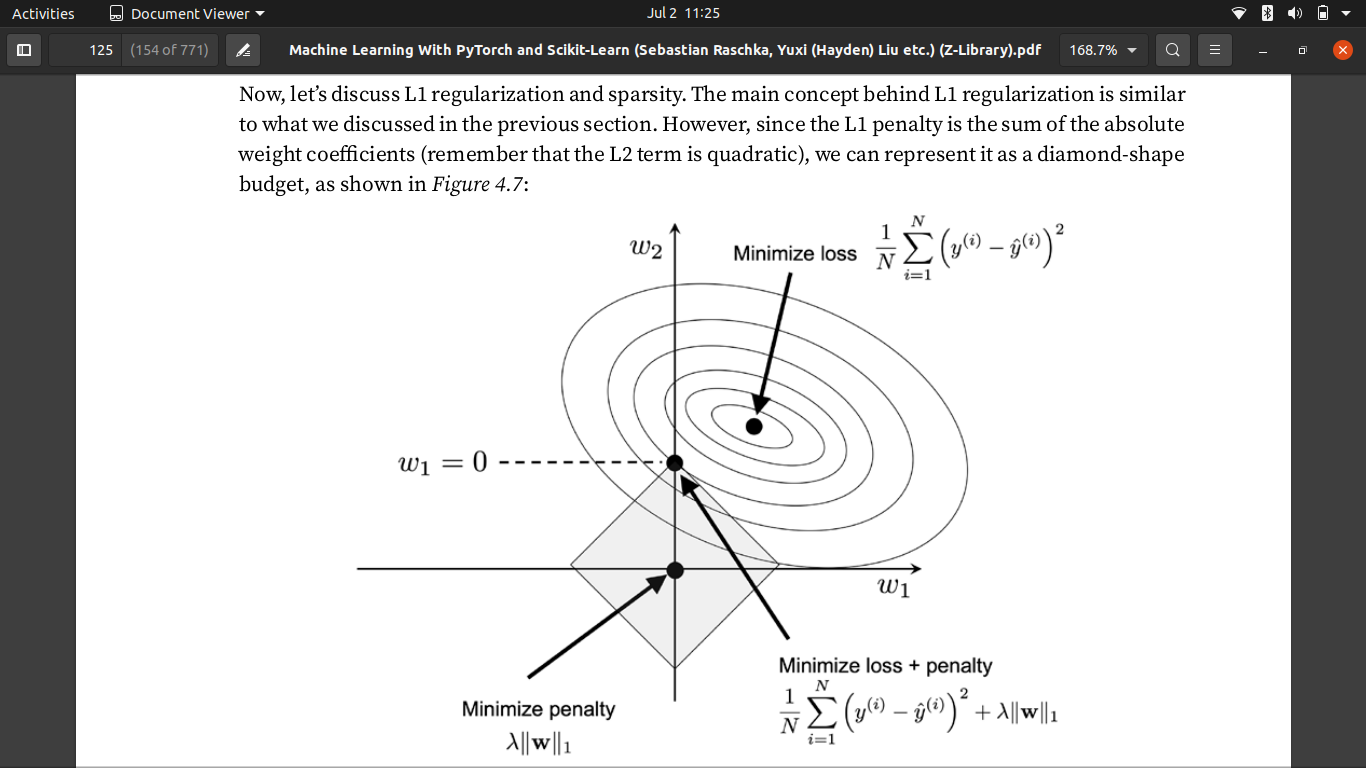

In the preceding figure, we can see that the contour of the loss function touches the L1 diamond at
w 1 = 0. Since the contours of an L1 regularized system are sharp, it is more likely that the optimum—that
is, the intersection between the ellipses of the loss function and the boundary of the L1 diamond—is
located on the axes, which encourages sparsity.

For regularized models in scikit-learn that support L1 regularization, we can simply set the penalty parameter to 'l1' to obtain a sparse solution:

In [47]:
from sklearn.linear_model import LogisticRegression

LogisticRegression(penalty='l1')

LogisticRegression(penalty='l1')

Applied to the standardized Wine data ...



In [48]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', multi_class='ovr')
# Note that C=1.0 is the default. You can increase
# or decrease it to make the regulariztion effect
# stronger or weaker, respectively.
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


Note that we also need to select a different optimization algorithm (for example, solver='liblinear' ),
since 'lbfgs' currently does not support L1-regularized loss optimization. Applied to the standardized
Wine data, the L1 regularized logistic regression would yield the following sparse solution:

Both training and test accuracies (both 100 percent) indicate that our model does a perfect job on
both datasets. When we access the intercept terms via the lr.intercept_ attribute, we can see that
the array returns three values:

In [49]:
lr.intercept_

array([-1.26351669, -1.21590785, -2.37016106])

Since we fit the LogisticRegression object on a multiclass dataset via the one-versus-rest (OvR)
approach, the first intercept belongs to the model that fits class 1 versus classes 2 and 3, the second
value is the intercept of the model that fits class 2 versus classes 1 and 3, and the third value is the
intercept of the model that fits class 3 versus classes 1 and 2:

In [ ]:
lr.coef_

The weight array that we accessed via the lr.coef_ attribute contains three rows of weight coefficients,
one weight vector for each class. Each row consists of 13 weights, where each weight is multiplied by
the respective feature in the 13-dimensional Wine dataset to calculate the net input:

> Accessing the bias unit and weight parameters of scikit-learn estimators.
In scikit-learn, intercept_ corresponds to the bias unit and coef_ corresponds to the
values wj .

In [50]:
np.set_printoptions(8)

In [51]:
lr.coef_[lr.coef_!=0].shape

(23,)

In [52]:
lr.coef_

array([[ 1.24568855,  0.18043214,  0.74510051, -1.16276378,  0.        ,
         0.        ,  1.16444397,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55303718,  2.50959567],
       [-1.53718058, -0.3873861 , -0.99557776,  0.3650456 , -0.05931566,
         0.        ,  0.66824257,  0.        ,  0.        , -1.93399983,
         1.23391138,  0.        , -2.23152583],
       [ 0.13560266,  0.1684345 ,  0.35723473,  0.        ,  0.        ,
         0.        , -2.43801109,  0.        ,  0.        ,  1.56373764,
        -0.81896646, -0.49233712,  0.        ]])

As a result of L1 regularization, which, as mentioned, serves as a method for feature selection, we just
trained a model that is robust to the potentially irrelevant features in this dataset. Strictly speaking,
though, the weight vectors from the previous example are not necessarily sparse because they contain
more non-zero than zero entries. However, we could enforce sparsity (more zero entries) by further
increasing the regularization strength—that is, choosing lower values for the C parameter.
In the last example on regularization in this chapter, we will vary the regularization strength and plot
the regularization path—the weight coefficients of the different features for different regularization
strengths:

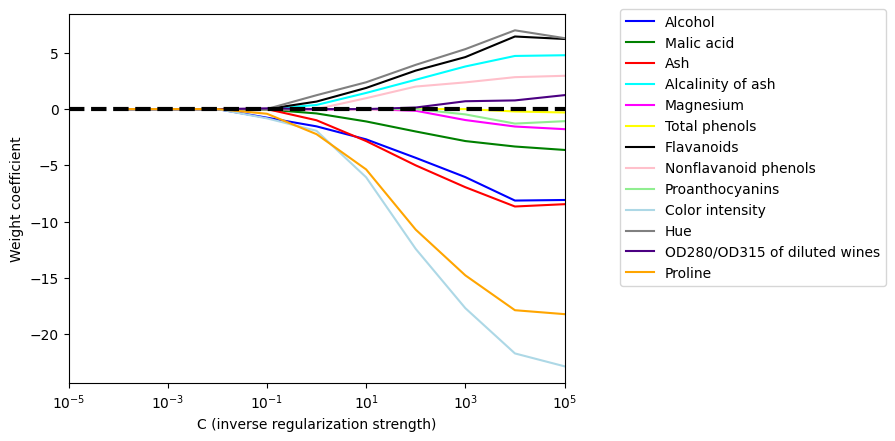

In [53]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear', 
                            multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('Weight coefficient')
plt.xlabel('C (inverse regularization strength)')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)

#plt.savefig('figures/04_08.png', dpi=300, 
#            bbox_inches='tight', pad_inches=0.2)

plt.show()

The resulting plot provides us with further insights into the behavior of L1 regularization. As we can
see, all feature weights will be zero if we penalize the model with a strong regularization parameter
(C < 0.01); C is the inverse of the regularization parameter, 𝜆 :

Sequential feature selection algorithms


An alternative way to reduce the complexity of the model and avoid overfitting is dimensionality
reduction via feature selection, which is especially useful for unregularized models. There are two
main categories of dimensionality reduction techniques: feature selection and feature extraction. Via
feature selection, we select a subset of the original features, whereas in feature extraction, we derive
information from the feature set to construct a new feature subspace.

In this section, we will take a look at a classic family of feature selection algorithms. In the next chapter,
Chapter 5, Compressing Data via Dimensionality Reduction, we will learn about different feature extraction
techniques to compress a dataset onto a lower-dimensional feature subspace.

Sequential feature selection algorithms are a family of greedy search algorithms that are used to
reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k<d. The
motivation behind feature selection algorithms is to automatically select a subset of features that are
most relevant to the problem, to improve computational efficiency, or to reduce the generalization
error of the model by removing irrelevant features or noise, which can be useful for algorithms that
don’t support regularization.

A classic sequential feature selection algorithm is sequential backward selection (SBS), which aims to
reduce the dimensionality of the initial feature subspace with a minimum decay in the performance
of the classifier to improve upon computational efficiency. In certain cases, SBS can even improve
the predictive power of the model if a model suffers from overfitting.

The idea behind the SBS algorithm is quite simple: SBS sequentially removes features from the full
feature subset until the new feature subspace contains the desired number of features. To determine
which feature is to be removed at each stage, we need to define the criterion function, J, that we want
to minimize.

The criterion calculated by the criterion function can simply be the difference in the performance of
the classifier before and after the removal of a particular feature. Then, the feature to be removed at
each stage can simply be defined as the feature that maximizes this criterion; or in more simple terms,
at each stage we eliminate the feature that causes the least performance loss after removal. Based on
the preceding definition of SBS, we can outline the algorithm in four simple steps:

1. Initialize the algorithm with k = d, where d is the dimensionality of the full feature space, X d .
2. Determine the feature, x – , that maximizes the criterion: x – = argmax J(X k – x), where 𝒙𝒙 𝒙 𝒙𝒙 𝑘𝑘 .
3. Remove the feature, x – , from the feature set: X k–1 = X k – x – ; k = k – 1.
4. Terminate if k equals the number of desired features; otherwise, go to step 2.

In [54]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS:
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In the preceding implementation, we defined the k_features parameter to specify the desired number
of features we want to return. By default, we use accuracy_score from scikit-learn to evaluate the
performance of a model (an estimator for classification) on the feature subsets.

Inside the while loop of the fit method, the feature subsets created by the itertools.combination
function are evaluated and reduced until the feature subset has the desired dimensionality. In each
iteration, the accuracy score of the best subset is collected in a list, self.scores_ , based on the inter-
nally created test dataset, X_test . We will use those scores later to evaluate the results. The column
indices of the final feature subset are assigned to self.indices_ , which we can use via the transform
method to return a new data array with the selected feature columns. Note that, instead of calculating
the criterion explicitly inside the fit method, we simply removed the feature that is not contained in
the best performing feature subset.

Now, let’s see our SBS implementation in action using the KNN classifier from scikit-learn.

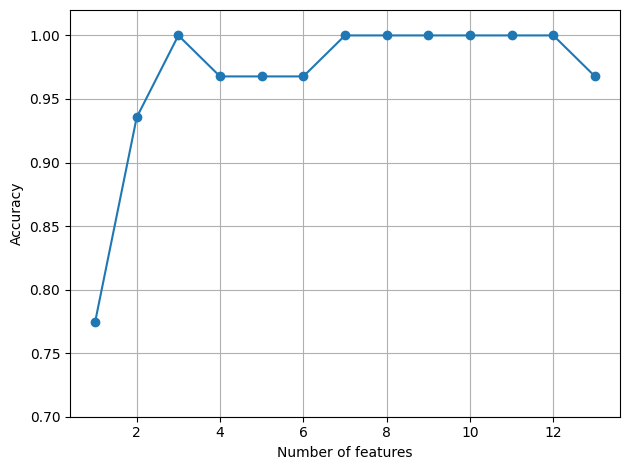

In [55]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('figures/04_09.png', dpi=300)
plt.show()

As we can see in Figure 4.9, the accuracy of the KNN classifier improved on the validation dataset as
we reduced the number of features, which is likely due to a decrease in the curse of dimensionality
that we discussed in the context of the KNN algorithm in Chapter 3. Also, we can see in the following
plot that the classifier achieved 100 percent accuracy for k = {3, 7, 8, 9, 10, 11, 12}:

In [56]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [57]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In the preceding code section, we used the complete feature set and obtained approximately 97 percent
accuracy on the training dataset and approximately 96 percent accuracy on the test dataset, which
indicates that our model already generalizes well to new data. Now, let’s use the selected three-feature
subset and see how well KNN performs:

In [58]:
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


When using less than a quarter of the original features in the Wine dataset, the prediction accuracy
on the test dataset declined slightly. This may indicate that those three features do not provide less
discriminatory information than the original dataset. However, we also have to keep in mind that the
Wine dataset is a small dataset and is very susceptible to randomness—that is, the way we split the
dataset into training and test subsets, and how we split the training dataset further into a training
and validation subset.

While we did not increase the performance of the KNN model by reducing the number of features,
we shrank the size of the dataset, which can be useful in real-world applications that may involve
expensive data collection steps. Also, by substantially reducing the number of features, we obtain
simpler models, which are easier to interpret.

### Assessing feature importance with Random Forests


In previous sections, you learned how to use L1 regularization to zero out irrelevant features via logistic
regression and how to use the SBS algorithm for feature selection and apply it to a KNN algorithm.
Another useful approach for selecting relevant features from a dataset is using a random forest, an en-
semble technique that was introduced in Chapter 3. 

Using a random forest, we can measure the feature importance as the averaged impurity 
decrease computed from all decision trees in the forest, without making any assumptions 
about whether our data is linearly separable or not. Conveniently, the random
forest implementation in scikit-learn already collects the feature importance values for us so that we
can access them via the feature_importances_ attribute after fitting a RandomForestClassifier.

By executing the following code, we will now train a forest of 500 trees on the Wine dataset and rank the
13 features by their respective importance measures—remember from our discussion in Chapter 3 that
we don’t need to use standardized or normalized features in tree-based models:

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


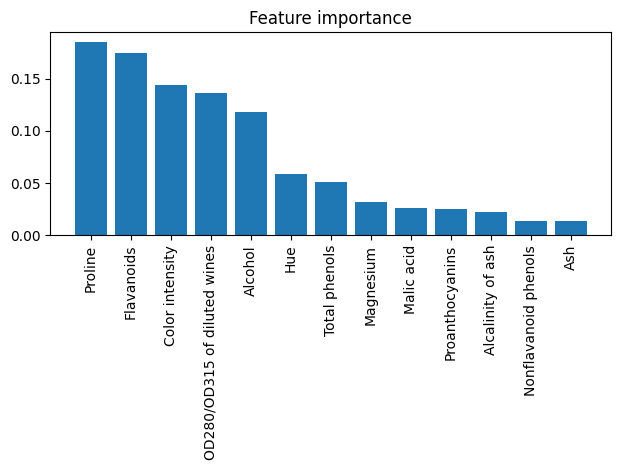

In [59]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
# plt.savefig('figures/04_10.png', dpi=300)
plt.show()

We can conclude that the proline and flavonoid levels, the color intensity, the OD280/OD315 diffraction,
and the alcohol concentration of wine are the most discriminative features in the dataset based on
the average impurity decrease in the 500 decision trees. Interestingly, two of the top-ranked features
in the plot are also in the three-feature subset selection from the SBS algorithm that we implemented
in the previous section (alcohol concentration and OD280/OD315 of diluted wines).

However, as far as interpretability is concerned, the random forest technique comes with an import-
ant gotcha that is worth mentioning. If two or more features are highly correlated, one feature may
be ranked very highly while the information on the other feature(s) may not be fully captured. On
the other hand, we don’t need to be concerned about this problem if we are merely interested in the
predictive performance of a model rather than the interpretation of feature importance values.

To conclude this section about feature importance values and random forests, it is worth mentioning
that scikit-learn also implements a SelectFromModel object that selects features based on a user-spec-
ified threshold after model fitting, which is useful if we want to use the RandomForestClassifier as
a feature selector and intermediate step in a scikit-learn Pipeline object, which allows us to connect
different preprocessing steps with an estimator, as you will see in Chapter 6, Learning Best Practices
for Model Evaluation and Hyperparameter Tuning. For example, we could set the threshold to 0.1 to
reduce the dataset to the five most important features using the following code:

In [60]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold criterion:', 
      X_selected.shape[1])

Number of features that meet this threshold criterion: 5


Now, let's print the 3 features that met the threshold criterion for feature selection that we set earlier (note that this code snippet does not appear in the actual book but was added to this notebook later for illustrative purposes):

In [61]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529


In [62]:
!jupyter nbconvert --to script  chapter_4.ipynb --output ch04

[NbConvertApp] Converting notebook chapter_4.ipynb to script
[NbConvertApp] Writing 14609 bytes to ch04.py
